In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sc_stats
import json
import random
import seaborn as sns
import re

import spacy

# Text analysis
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SpanishStemmer
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('tokenizers/punkt/spanish.pickle')
nltk.download('stopwords')

import unicodedata

from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LinearRegression

import analysis_utils as aute

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\demos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading tokenizers/punkt/spanish.pickle: Package
[nltk_data]     'tokenizers/punkt/spanish.pickle' not found in index
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\demos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
rdm_th = 0
corr_th = 0.85

nlp_spanish = spacy.load("es_core_news_sm")

random.seed(rdm_th)

In [3]:
with open('../LableniBotConfig/avoid_words.json', encoding='utf-8') as fh:
    avoid_words_list = json.load(fh)

tokenize_spanish = nltk.data.load('tokenizers/punkt/spanish.pickle')
spanish_stemmer = SpanishStemmer()
spanish_stopwords_th = stopwords.words('spanish')

In [6]:
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

Only conversations with more than 5 sentences are taken in account.

In [9]:
path_to_conversations = "../Conversations/"

all_df_list = []
for conv in os.listdir(path_to_conversations):
    excel_name = [file for file in os.listdir(path_to_conversations + conv) if ".pkl" in file][0]
    try:
        df_x = pd.read_pickle(path_to_conversations + conv + "/" + excel_name)
        if df_x.shape[0] > 2:
            all_df_list.append(df_x)
    except:
        print("Bad file", conv + "/" + excel_name)
            
print("Number of conversations:", len(all_df_list))

Number of conversations: 8


In [10]:
def clean_word(word):
    special_characters = ["?", "¿", "!", "¡", ".", ","]
    w_new = word.lower()
    for s_c in special_characters:
        w_new = w_new.replace(s_c, "")
        
    return w_new

def avoid_words_func(text):
    return " ".join([w for w in text.split() if clean_word(w) not in avoid_words_list])

def clean_text(text, subject_name, 
               tokenize_spanish=tokenize_spanish, 
               spanish_stopwords_th=spanish_stopwords_th, 
               spanish_stemmer=spanish_stemmer, 
               use_stemmer=True):
    
    text = text.lower()
    text = text.replace('?', "").replace('¿', "").replace('!', "").replace('¡', "")
    if subject_name:
        text = text.replace(subject_name, "")
    text = strip_accents(text)
    
    text_token_list = []
    if use_stemmer:
        for word in text.split():
            token_text = tokenize_spanish.tokenize(word)
            if len(token_text) > 0 and word not in spanish_stopwords_th:
                text_token_list.append(spanish_stemmer.stem(token_text[0]))
    else:
        text_token_list.append(text)
            
    text = " ".join(text_token_list)
    
    return text

In [11]:
def include_time_columns(data, col_name_init, col_name_end, label):
    
    delta_time = data[col_name_end] - data[col_name_init]

    return {
        "Mean_" + label: np.nanmean(delta_time),
        "Max_" + label: np.nanmax(delta_time),
        "Min_" + label: np.nanmin(delta_time),
        "Diff_" + label: delta_time.dropna().iloc[-1] - delta_time.dropna().iloc[0],
    }


def get_text_metrics(data, subject_name, label):
        
    text = ". ".join(data["SpanishMessage"].values)
    my_clean_text = clean_text(text, subject_name)
    
    num_words_text = len(my_clean_text.split(" "))

    dict_results = {
        label + "Text": avoid_words_func(my_clean_text),
        label + "NumUniqWords": len(set([w for w in my_clean_text.split() if w.isalpha()])),
        label + "OriginalText": avoid_words_func( ". ".join(data["SpanishMessage"].values) ),
        label + "NumWords": num_words_text,
    }

    return dict_results

In [12]:
save_res_list = []
for i_df_x, df_x in enumerate(all_df_list):
    
    result_dict = {}

    subject_name = df_x["SubjectId"].iloc[0]
    
    # ###############
    # ### General ###
    # ###############
    num_conv = df_x.shape[0] // 2
    
    text = ". ".join(df_x["SpanishMessage"].values)
    whole_text = clean_text(text, subject_name)
    
    num_words = len(whole_text.split(" "))
    conv_time_s = df_x["S2TEndUnix"].iloc[-1] - df_x["UnixTimestampLoopInit"].iloc[0]
    # freq_conv_s = np.mean(df_x["unixtimestamp"].values[1:] - df_x["unixtimestamp"].values[:-1])
    
    result_dict["SubjectId"] = df_x["SubjectId"].iloc[0]
    result_dict["FirstDate"] = df_x["UnixTimestampLoopInit"].iloc[0]
    result_dict["LastDate"] = df_x["S2TEndUnix"].iloc[-1]
    result_dict["ConvTime_s"] = conv_time_s

    result_dict["NumConv"] = num_conv
    result_dict["NumSamples"] = df_x.shape[0]

    x = get_text_metrics(data=df_x, subject_name=subject_name, label="All")
    result_dict.update(x)

    # ###########
    # ### Bot ###
    # ###########
    df_bot = df_x[df_x["Source"] == "Bot"]

    x = get_text_metrics(data=df_bot, subject_name=subject_name, label="Bot")
    result_dict.update(x)

    dict_time_openai = include_time_columns(data=df_bot, col_name_init="BotStartUnix", col_name_end="BotEndUnix", label="OpenAI")
    dict_time_aws = include_time_columns(data=df_bot, col_name_init="AWSStartUniX", col_name_end="AWSEndUniX", label="AWS")
    dict_time_bottalk = include_time_columns(data=df_bot, col_name_init="BotTalkStartUnix", col_name_end="BotTalkEndUnix", label="BotTalk")

    # ##############
    # ### Person ###
    # ##############
    df_person = df_x[df_x["Source"] == "Person"]

    x = get_text_metrics(data=df_person, subject_name=subject_name, label="Person")
    result_dict.update(x)
    
    dict_time_s2t = include_time_columns(data=df_person, col_name_init="S2TStartUnix", col_name_end="S2TEndUnix", label="OpenAI")
    dict_time_pertalk = include_time_columns(data=df_person, col_name_init="PersonTalkStartUnix", col_name_end="PersonTalkEndUnix", label="PersonTalk")

    # ### Save the rest of times computed ###

    result_dict.update(dict_time_openai)
    result_dict.update(dict_time_aws)
    result_dict.update(dict_time_bottalk)
    result_dict.update(dict_time_pertalk)
    result_dict.update(dict_time_s2t)

    save_res_list.append(result_dict)
    
df_save = pd.DataFrame(save_res_list)
df_save.head(5)

,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,Min_AWS,Diff_AWS,Mean_BotTalk,Max_BotTalk,Min_BotTalk,Diff_BotTalk,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk
0,Alejandro,1.665395e+09,1.665395e+09,215.250305,9,18,"hola, nombr llam tu. hola, llam alex. hol alex...",63,"Hola, mi nombre es ¿Cómo te llamas tú?. hola, ...",141,...,0.093742,-0.243478,7.453963,10.633201,4.429088,2.223547,11.541201,15.850620,6.194982,6.362520
1,Alejandro,1.665395e+09,1.665396e+09,282.038996,15,30,"hola, nombr alejandr llam tu. miriam alejandro...",91,"Hola, mi nombre es Alejandro ¿Cómo te llamas t...",183,...,0.064825,-0.220923,7.409354,26.951323,2.648327,-2.325912,7.086196,15.840486,6.203408,0.012190
2,Alejandro,1.665396e+09,1.665396e+09,163.489967,9,18,"hola, nombr mari llam tu. hol mari alex tal. h...",46,"Hola, mi nombre es ¿Cómo te llamas tú?. hola s...",97,...,0.097734,-0.180508,5.918260,9.524444,2.164783,-2.980209,8.761743,22.374247,6.223196,3.207338
3,Alejandro,1.665396e+09,1.665396e+09,155.050430,7,14,"hola, nombr daniel llam tu. gabriel dicho. ah,...",56,"Hola, mi nombre es Daniel ¿Cómo te llamas tú?....",105,...,0.062831,-0.211430,8.193665,21.867001,4.763348,0.713056,9.479692,22.408216,6.225244,0.012462
4,Alejandro,1.665396e+09,1.665397e+09,150.900022,5,10,"hola, nombr mart llam tu. buenas, marta, llam ...",48,"Hola, mi nombre es Marta ¿Cómo te llamas tú?. ...",100,...,0.116687,-0.190488,14.929486,25.502450,5.474934,20.027516,8.812869,15.867685,6.225132,-0.014510


In [13]:
print("Shape", df_save.shape)
print("Columns", df_save.columns)

Shape (8, 34)
Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'BotText', 'BotNumUniqWords', 'BotOriginalText',
       'BotNumWords', 'PersonText', 'PersonNumUniqWords', 'PersonOriginalText',
       'PersonNumWords', 'Mean_OpenAI', 'Max_OpenAI', 'Min_OpenAI',
       'Diff_OpenAI', 'Mean_AWS', 'Max_AWS', 'Min_AWS', 'Diff_AWS',
       'Mean_BotTalk', 'Max_BotTalk', 'Min_BotTalk', 'Diff_BotTalk',
       'Mean_PersonTalk', 'Max_PersonTalk', 'Min_PersonTalk',
       'Diff_PersonTalk'],
      dtype='object')


## EDA

In [14]:
aute.stat_print(df_save["ConvTime_s"]/60, "Conversation time (min)", 2)
aute.stat_print(df_save["NumSamples"], "Number Sentences ", 2)

Mean Conversation time (min) = 3.06 +/- 0.71 ; Median = 2.69 ; Min. =  2.52 ; Max. =  4.7
Mean Number Sentences  = 18.0 +/- 5.66 ; Median = 18.0 ; Min. =  10 ; Max. =  30


### Some plots

#### EDA in Words

The following plots study the correlation of the number of words against the number of sentences and the time of the conversation. 

Correlation value 0.8501272771022875
P-value **
Coefficients: 
 [8.125] 
Intercept: 
 47.875
R-square: 0.72


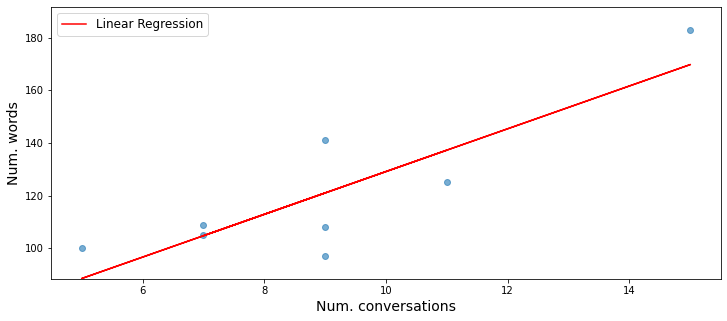

Correlation value 0.9820860790301741
P-value ***
Coefficients: 
 [0.62063905] 
Intercept: 
 7.190220195354698
R-square: 0.96


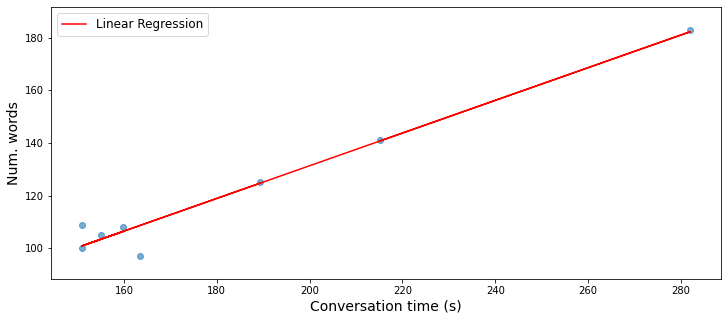

In [15]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="NumConv", x_name="Num. conversations", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="ConvTime_s", x_name="Conversation time (s)", 
                       y_feat="AllNumWords", y_name="Num. words", 
                       lr_mode=True)

Mean All number of words = 121.0 +/- 27.0324 ; Median = 108.5 ; Min. =  97 ; Max. =  183
Mean Person number of words = 48.0 +/- 15.8981 ; Median = 46.0 ; Min. =  22 ; Max. =  82
Mean Bot number of words = 73.0 +/- 22.809 ; Median = 66.0 ; Min. =  52 ; Max. =  130
P-value 0.032132890167037804 string p value *


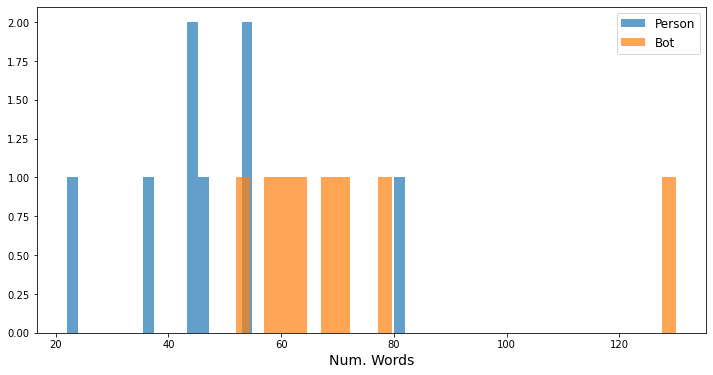

Mean All unique number of words = 53.75 +/- 15.7619 ; Median = 47.0 ; Min. =  41 ; Max. =  91
Mean Person unique words = 23.75 +/- 9.0933 ; Median = 24.0 ; Min. =  10 ; Max. =  43
Mean Bot unique words = 36.625 +/- 13.1713 ; Median = 33.5 ; Min. =  26 ; Max. =  70
P-value 0.05155747119403436 string p value -


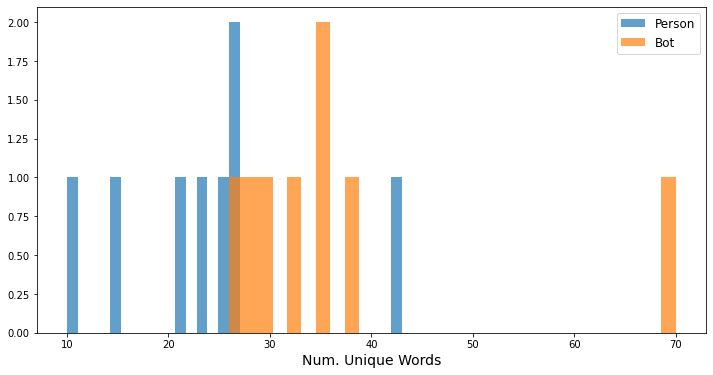

In [16]:
# #######################
# ### Number of words ###
# #######################

aute.stat_print(df_save["AllNumWords"].values, "All number of words")
aute.stat_print(df_save["PersonNumWords"].values, "Person number of words")
aute.stat_print(df_save["BotNumWords"].values, "Bot number of words")
_, p = sc_stats.f_oneway(df_save["PersonNumWords"].values, df_save["BotNumWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

# ####################
# ### Unique words ###
# ####################

aute.stat_print(df_save["AllNumUniqWords"].values, "All unique number of words")
aute.stat_print(df_save["PersonNumUniqWords"].values, "Person unique words")
aute.stat_print(df_save["BotNumUniqWords"].values, "Bot unique words")
_, p = sc_stats.f_oneway(df_save["PersonNumUniqWords"].values, df_save["BotNumUniqWords"].values)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(12, 6))

plt.hist(df_save["PersonNumUniqWords"].values, bins=31, alpha=0.7, label="Person")
plt.hist(df_save["BotNumUniqWords"].values, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Num. Unique Words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

#### EDA in times

In [17]:
check_list = []
for df in all_df_list:
    
    dict_data = {
        "NumRows": df.shape[0],
        "NumCols": df.shape[1],
        "TimeConversation_min": (df["S2TEndUnix"].iloc[-1] - df["UnixTimestampLoopInit"].iloc[0])/60,
    }
    
    dict_res = include_time_columns(df, col_name_init="AWSStartUniX", col_name_end="AWSEndUniX", label="AWS")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="S2TStartUnix", col_name_end="S2TEndUnix", label="GoogleS2T")
    dict_data.update(dict_res)
    
    dict_res = include_time_columns(df, col_name_init="BotStartUnix", col_name_end="BotEndUnix", label="OpenAI")
    dict_data.update(dict_res)
    
    check_list.append(dict_data)
    
df_check = pd.DataFrame(check_list)

Mean Number of rows = 18.0 +/- 5.6569 ; Median = 18.0 ; Min. =  10 ; Max. =  30



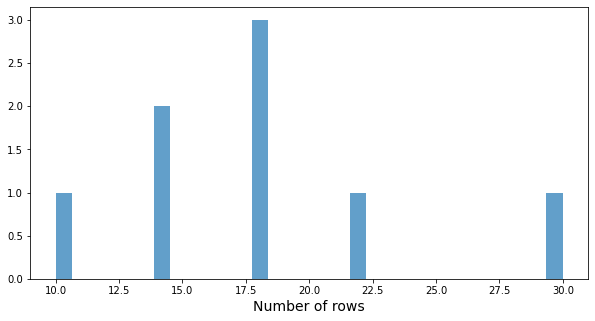

Mean Number of cols = 21.0 +/- 0.0 ; Median = 21.0 ; Min. =  21 ; Max. =  21

Mean Time conversation (min) = 3.0563 +/- 0.7129 ; Median = 2.6946 ; Min. =  2.515 ; Max. =  4.7006



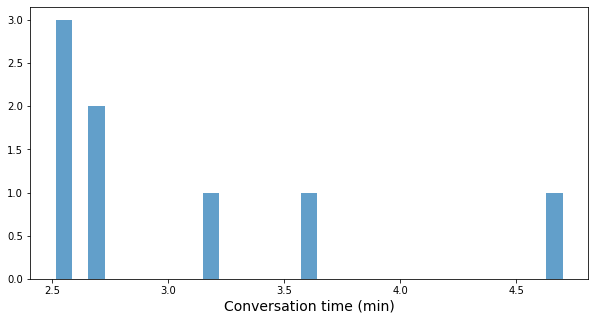

In [18]:
aute.stat_print(df_check["NumRows"], "Number of rows")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["NumRows"], bins=31, alpha=0.7)
plt.xlabel("Number of rows", fontsize=14)

plt.show()

aute.stat_print(df_check["NumCols"], "Number of cols")
print()

aute.stat_print(df_check["TimeConversation_min"], "Time conversation (min)")
print()

plt.figure(figsize=(10, 5))

plt.hist(df_check["TimeConversation_min"], bins=31, alpha=0.7)
plt.xlabel("Conversation time (min)", fontsize=14)

plt.show()

Mean Mean_OpenAItime_s = 1.7583 +/- 0.5102 ; Median = 1.7216 ; Min. =  1.0561 ; Max. =  2.9031
Mean Mean_AWStime_s = 0.1211 +/- 0.0269 ; Median = 0.1158 ; Min. =  0.0929 ; Max. =  0.1707
Mean Mean_S2Ttime_s = 1.5491 +/- 0.2217 ; Median = 1.5235 ; Min. =  1.3191 ; Max. =  2.0412


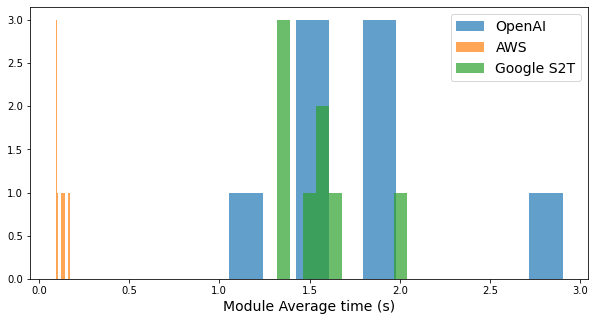

In [19]:
aute.stat_print(df_check["Mean_OpenAI"], "Mean_OpenAItime_s")
aute.stat_print(df_check["Mean_AWS"], "Mean_AWStime_s")
aute.stat_print(df_check["Mean_GoogleS2T"], "Mean_S2Ttime_s")

plt.figure(figsize=(10, 5))

plt.hist(df_check["Mean_OpenAI"], alpha=0.7, label="OpenAI")
plt.hist(df_check["Mean_AWS"], alpha=0.7, label="AWS")
plt.hist(df_check["Mean_GoogleS2T"], alpha=0.7, label="Google S2T")

plt.legend(fontsize=14)
plt.xlabel("Module Average time (s)", fontsize=14)

plt.show()

In [20]:
save_time_dict = {
    "AWS_t": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "Google_S2T": {
        "num_words": [],
        "num_characters": [],
        "time": []
    },
    "OpenAI": {
        "num_words": [],
        "num_characters": [],
        "time": []
    }
}
for df in all_df_list:

    df_person = df[df["Source"]=="Person"]
    df_bot = df[df["Source"]=="Bot"]

    for i in range(df_bot.shape[0]):
        bot_sentence = df_bot["SpanishMessage"].iloc[i]
        num_all_words = len( "".join(re.findall(r'\w+', bot_sentence)) )
        save_time_dict["AWS_t"]["num_words"].append( num_all_words )
        save_time_dict["AWS_t"]["num_characters"].append( len(bot_sentence) )
        save_time_dict["AWS_t"]["time"].append( df_bot["AWSEndUniX"].iloc[i] - df_bot["AWSStartUniX"].iloc[i] )
    
    for i in range(df_person.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_person["SpanishMessage"].iloc[i])) )
        save_time_dict["Google_S2T"]["num_words"].append( num_all_words )
        save_time_dict["Google_S2T"]["num_characters"].append( len(df_person["SpanishMessage"].iloc[i]) )
        save_time_dict["Google_S2T"]["time"].append( df_person["S2TEndUnix"].iloc[i] - df_person["S2TStartUnix"].iloc[i] )

    for i in range(df_bot.shape[0]):
        num_all_words = len( "".join(re.findall(r'\w+', df_bot["GlobalMessage"].iloc[i])) )
        save_time_dict["OpenAI"]["num_words"].append( num_all_words )
        save_time_dict["OpenAI"]["num_characters"].append( len(df_bot["GlobalMessage"].iloc[i]) )
        save_time_dict["OpenAI"]["time"].append( df_bot["BotTalkEndUnix"].iloc[i] - df_bot["BotTalkStartUnix"].iloc[i] )

<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\demos\AppData\Local\Temp\ipykernel_2068\2206526206.py:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  min_num_words = np.min([np.min(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])
C:\Users\demos\AppData\Local\Temp\ipykernel_2068\2206526206.py:2: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  max_num_words = np.max([np.max(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])
C:\Users\demos\AppData\Local\Temp\ipykernel_2068\2206526206.py:8: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if k is not "OpenAI

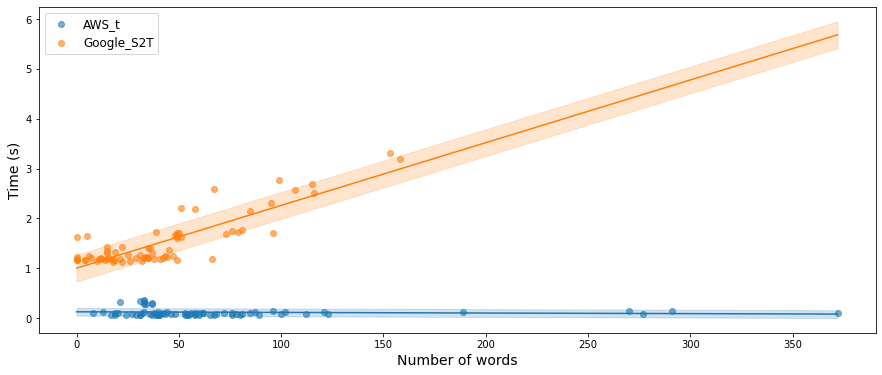

In [21]:
min_num_words = np.min([np.min(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])
max_num_words = np.max([np.max(v["num_words"]) for k, v in save_time_dict.items() if k is not "OpenAI"])

plt.figure(figsize=(15, 6))

for i, (k, v) in enumerate(save_time_dict.items()):
    
    if k is not "OpenAI":
    
        sort_x_idx = np.argsort(v["num_words"])
        y_time = np.array(v["time"])[sort_x_idx]
        x_len_text = np.array(v["num_words"])[sort_x_idx]

        x_to_lr = np.array(x_len_text).reshape(-1, 1)
        lr = LinearRegression(n_jobs=-1)
        lr.fit(x_to_lr, y_time)
        y_pred = lr.predict(x_to_lr)

        err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
        y_time_plus = y_pred + err_pred
        y_time_minus = y_pred - err_pred

        x_lim_min_max = np.array([max_num_words, min_num_words])
        y_lim_min_max = lr.predict(x_lim_min_max.reshape(-1, 1))

        plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
        plt.plot(x_lim_min_max, y_lim_min_max, color=aute.PLT_DEFAULT_COLORS[i])
        plt.fill_between(x_lim_min_max, 
                         y_lim_min_max + err_pred, 
                         y_lim_min_max - err_pred, 
                         alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

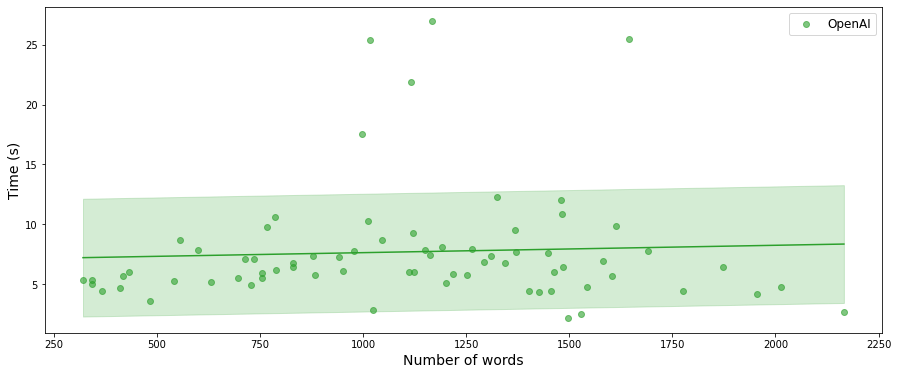

In [22]:
k = "OpenAI"
v = save_time_dict[k]

plt.figure(figsize=(15, 6))
    
sort_x_idx = np.argsort(v["num_words"])
y_time = np.array(v["time"])[sort_x_idx]
x_len_text = np.array(v["num_words"])[sort_x_idx]

x_to_lr = np.array(x_len_text).reshape(-1, 1)
lr = LinearRegression(n_jobs=-1)
lr.fit(x_to_lr, y_time)
y_pred = lr.predict(x_to_lr)

err_pred = np.sqrt( np.sum((y_time - y_pred)**2)/(len(y_time)-1-1) )
y_time_plus = y_pred + err_pred
y_time_minus = y_pred - err_pred


plt.plot(x_len_text, y_pred, color=aute.PLT_DEFAULT_COLORS[i])
plt.scatter(x_len_text, y_time, label=k, alpha=0.6, color=aute.PLT_DEFAULT_COLORS[i])
plt.fill_between(x_len_text, y_time_plus, y_time_minus, alpha=0.2, color=aute.PLT_DEFAULT_COLORS[i])

plt.legend(fontsize=12)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.show()

In [25]:
resource_name_list = ["OpenAItime_s", "AWStime_s", "S2Ttime_s"]
save_time_list = []
counter = 0
for df in all_df_list:
    
    max_index_take = df[df["Source"] == "Bot"].index[-1]
    df_to_study = df.loc[1:(max_index_take+1)].reset_index(drop=True)

    n_iter = (df_to_study.shape[0] // 2)

    for i in range(n_iter):

        delta_aws_t = (df_to_study["AWSEndUniX"].iloc[2*i+1] - df_to_study["AWSStartUniX"].iloc[2*i+1])
        delta_s2t_t = (df_to_study["S2TEndUnix"].iloc[2*i] - df_to_study["S2TStartUnix"].iloc[2*i])
        delta_bot_t = (df_to_study["BotEndUnix"].iloc[2*i+1] - df_to_study["BotStartUnix"].iloc[2*i+1])

        total_time = df_to_study["BotTalkStartUnix"].iloc[2*i+1] - df_to_study["PersonTalkEndUnix"].iloc[2*i]
        rest_time = total_time - delta_bot_t - delta_s2t_t - delta_aws_t

        all_times_list = [
            (delta_aws_t, "AWS"), 
            (delta_s2t_t, "S2T"), 
            (delta_bot_t, "OpenAI"), 
            (total_time, "Total"), 
            (rest_time, "Rest")
        ]
        
        for elt in all_times_list:
            save_time_list.append({
                "Iteration": counter,
                "Source": elt[1],
                "Time": elt[0]
            })

        counter += 1
        
df_times = pd.DataFrame(save_time_list)
print("Shape", df_times.shape)

Shape (320, 3)


In [26]:
all_times_list = []
for g, df_g in df_times.groupby("Iteration"):
    dict_times = dict(zip(df_g["Source"].values.tolist(), df_g["Time"].values.tolist()))
    all_times_list.append(dict_times)
df_all_t_sources = pd.DataFrame(all_times_list)

df_all_t_sources.to_csv("../Documents/ResultsTable/SaveToBoxplot.csv", index=False)

In [27]:
for col in df_all_t_sources.columns:
    print("Source", col, "takes:")
    aute.stat_print(df_all_t_sources[col], col)
    print("In percentage", np.round(100 * np.sum(df_all_t_sources[col])/np.sum(df_all_t_sources["Total"]), 4), "%")
    print()

Source AWS takes:
Mean AWS = 0.0916 +/- 0.0363 ; Median = 0.0783 ; Min. =  0.0628 ; Max. =  0.3152
In percentage 1.9895 %

Source S2T takes:
Mean S2T = 1.5418 +/- 0.5245 ; Median = 1.284 ; Min. =  1.1264 ; Max. =  3.3095
In percentage 33.4723 %

Source OpenAI takes:
Mean OpenAI = 1.9029 +/- 1.1695 ; Median = 1.6531 ; Min. =  0.0 ; Max. =  6.3573
In percentage 41.3135 %

Source Total takes:
Mean Total = 4.6061 +/- 1.6073 ; Median = 4.4141 ; Min. =  1.6263 ; Max. =  9.8838
In percentage 100.0 %

Source Rest takes:
Mean Rest = 1.0698 +/- 0.4694 ; Median = 1.0871 ; Min. =  0.3151 ; Max. =  2.2869
In percentage 23.2247 %



In [28]:
all_diff = df_all_t_sources["Total"] - np.sum(df_all_t_sources[["Rest", "OpenAI", "S2T", "AWS"]], axis=1)
np.max(all_diff)

0.0

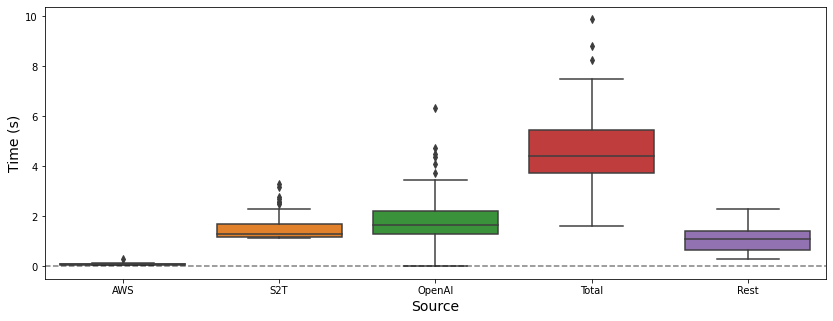

In [30]:
plt.figure(figsize=(14, 5))
sns.boxplot(x="Source", y="Time", data=df_times)

plt.axhline(0, c="black", linestyle="--", alpha=0.5)

plt.xlabel("Source", fontsize=14)
plt.ylabel("Time (s)", fontsize=14)

plt.savefig('../Documents/Images/save_boxplot.pdf', format='pdf')

plt.show()

### Crude Text 

#### Token size analysis

In [31]:
def obtain_word_analysis(data, target):
    result_list = []
    for text in data[target].tolist():
        
        original_text_clean = clean_text(text, subject_name=None, use_stemmer=False)
        sentence_list = [sentence for sentence in original_text_clean.split(".") if len(sentence) > 1]
        len_list = [len(sent.split()) for sent in sentence_list]
        
        result_list.append({
            "mean": np.mean(len_list),
            "median": np.median(len_list),
            "std": np.std(len_list),
            "num_words_in_sentence": len_list
        })

    return pd.DataFrame(result_list)

Mean Number of words for BOT by sentence = 9.096 +/- 6.1986 ; Median = 8.0 ; Min. =  1 ; Max. =  29
Mean Number of words for Person by sentence = 9.2763 +/- 6.8779 ; Median = 8.0 ; Min. =  1 ; Max. =  34
P-value 0.8488573467910782 string p value -


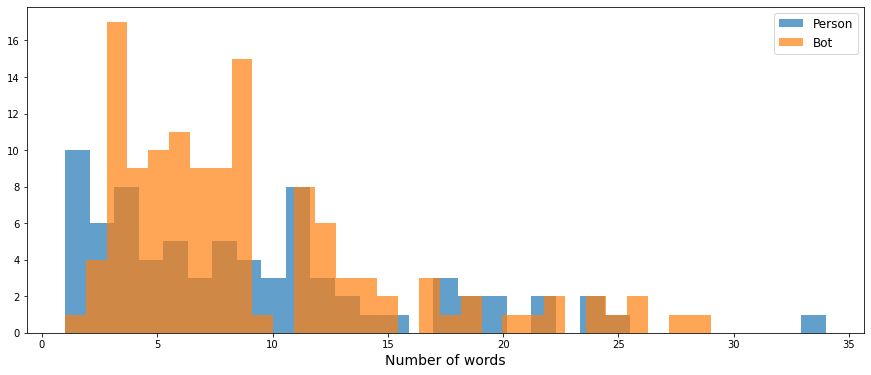

In [32]:
df_bot_result = obtain_word_analysis(df_save, "BotOriginalText")
df_person_result = obtain_word_analysis(df_save, "PersonOriginalText")

bot_word_number = []
for my_list in df_bot_result["num_words_in_sentence"].tolist():
    bot_word_number += my_list

person_word_number = []
for my_list in df_person_result["num_words_in_sentence"].tolist():
    person_word_number += my_list

aute.stat_print(bot_word_number, "Number of words for BOT by sentence")
aute.stat_print(person_word_number, "Number of words for Person by sentence")

_, p = sc_stats.f_oneway(person_word_number, bot_word_number)
print("P-value", p, "string p value", aute.get_p_string(p))

plt.figure(figsize=(15, 6))

plt.hist(person_word_number, bins=31, alpha=0.7, label="Person")
plt.hist(bot_word_number, bins=31, alpha=0.7, label="Bot")
plt.xlabel("Number of words", fontsize=14)
plt.legend(fontsize=12)

plt.show()

Mean Number of words for ALL by sentence = 9.1642 +/- 6.4644 ; Median = 8.0 ; Min. =  1 ; Max. =  34


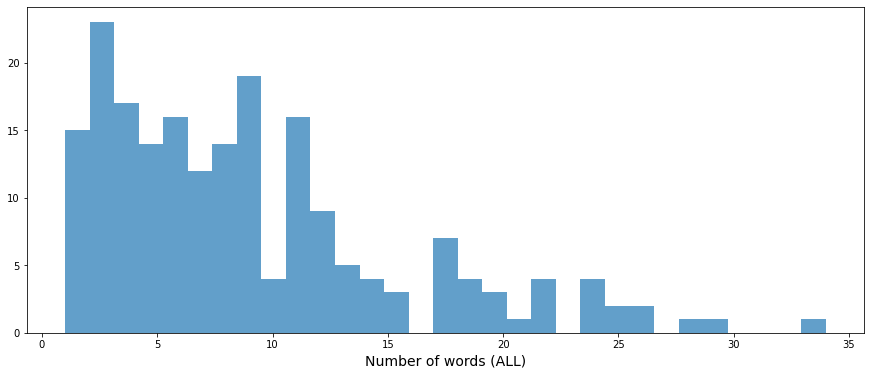

In [33]:
df_all_result = obtain_word_analysis(df_save, "AllOriginalText")

all_word_number = []
for my_list in df_all_result["num_words_in_sentence"].tolist():
    all_word_number += my_list

aute.stat_print(all_word_number, "Number of words for ALL by sentence")

plt.figure(figsize=(15, 6))

plt.hist(all_word_number, bins=31, alpha=0.7, label="All")
plt.xlabel("Number of words (ALL)", fontsize=14)

plt.show()

## WordCloud analysis

- Falta tokenizar las palabras, eliminar acentos y etc.

- Estaria bien establecer un protocolo para eliminar el nombre del sujeto.

- Estudiar el número y cuales son las stopwords localizadas en el Bot y en la persona. Ver si estas stopwords son las mismas para ambos o distintas, etc. Posiblemente el sujeto utilice más stopwords que el sujeto o quizá no. 

### Whole text

In [34]:
whole_text = " ".join(df_save["AllOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_words_list = [word for word in whole_text.split() if word not in spanish_stopwords_th]
uniq_words_list = list(set(all_words_list))
freq_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_words_list)==word)} for word in uniq_words_list
]
df_freq_all_words = pd.DataFrame(freq_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_all_words.head(15)

,Word,Times
0,gusta,24
1,pues,14
2,ahora,13
3,hola,13
4,si,13
5,bien,12
6,aquí,10
7,tú?,10
8,película,9
9,gracias,8


In [35]:
print("Number of different words", df_freq_all_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_all_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_all_words["Times"]), 5), 
      "Max", np.max(df_freq_all_words["Times"]), 
      "Min", np.min(df_freq_all_words["Times"]) )

Number of different words 474
Mean frequency 1.92194 +/- 2.1149 Max 24 Min 1


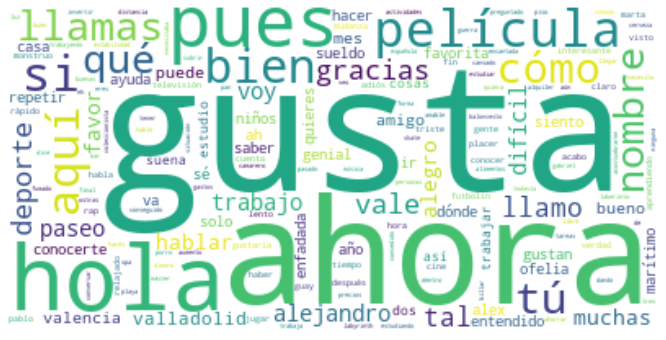

In [36]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Bot analysis

In [37]:
whole_bot_text = " ".join(df_save["BotOriginalText"]).replace(".", " ").replace(",", " ").lower()

all_bot_words_list = [word for word in whole_bot_text.split() if word not in spanish_stopwords_th]
uniq_bot_words_list = list(set(all_bot_words_list))
freq_bot_words_appear = [
    {"Word": word, "Times": np.sum(np.array(all_bot_words_list)==word)} for word in uniq_bot_words_list
]
df_freq_bot_words = pd.DataFrame(freq_bot_words_appear).sort_values("Times", ascending=False).reset_index(drop=True)
df_freq_bot_words.head(15)

,Word,Times
0,gusta,15
1,bien,10
2,hola,9
3,nombre,8
4,tú?,8
5,llamas,8
6,gracias,8
7,¿cómo,8
8,muchas,6
9,¿qué,6


In [38]:
print("Number of different words", df_freq_bot_words.shape[0])
print("Mean frequency", np.round(np.mean(df_freq_bot_words["Times"]), 5), 
      "+/-", np.round(np.std(df_freq_bot_words["Times"]), 5), 
      "Max", np.max(df_freq_bot_words["Times"]), 
      "Min", np.min(df_freq_bot_words["Times"]) )

Number of different words 319
Mean frequency 1.76803 +/- 1.60606 Max 15 Min 1


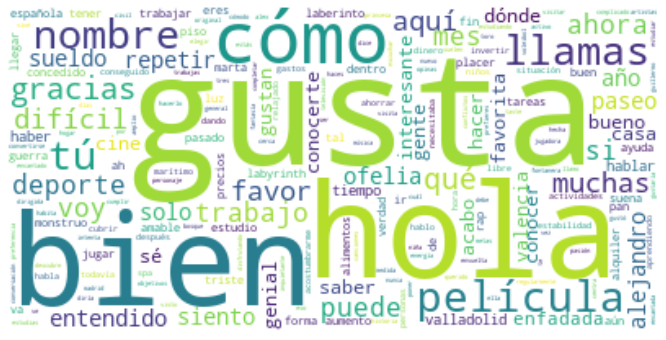

In [39]:
plt.figure(figsize=(15, 6))

all_wordcloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(all_bot_words_list))

plt.imshow(all_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analysis against Questionare

In [40]:
random_target = [np.random.randint(1, 5+1) for _ in range(df_save.shape[0])]
random_binary_target = [np.random.randint(0, 1+1) for _ in range(df_save.shape[0])]

In [41]:
df_save["MultilabelTarget"] = random_target
df_save["BinaryTarget"] = random_binary_target

In [42]:
aute.stat_print(df_save["MultilabelTarget"], "Realism degree score", precision=2)
aute.stat_print(100 * df_save["BinaryTarget"], "Repetition score", precision=2)

Mean Realism degree score = 2.38 +/- 1.41 ; Median = 2.0 ; Min. =  1 ; Max. =  5
Mean Repetition score = 62.5 +/- 48.41 ; Median = 100.0 ; Min. =  0 ; Max. =  100


In [43]:
print("Columns", df_save.columns)
df_save.head(5)

Columns Index(['SubjectId', 'FirstDate', 'LastDate', 'ConvTime_s', 'NumConv',
       'NumSamples', 'AllText', 'AllNumUniqWords', 'AllOriginalText',
       'AllNumWords', 'BotText', 'BotNumUniqWords', 'BotOriginalText',
       'BotNumWords', 'PersonText', 'PersonNumUniqWords', 'PersonOriginalText',
       'PersonNumWords', 'Mean_OpenAI', 'Max_OpenAI', 'Min_OpenAI',
       'Diff_OpenAI', 'Mean_AWS', 'Max_AWS', 'Min_AWS', 'Diff_AWS',
       'Mean_BotTalk', 'Max_BotTalk', 'Min_BotTalk', 'Diff_BotTalk',
       'Mean_PersonTalk', 'Max_PersonTalk', 'Min_PersonTalk',
       'Diff_PersonTalk', 'MultilabelTarget', 'BinaryTarget'],
      dtype='object')


,SubjectId,FirstDate,LastDate,ConvTime_s,NumConv,NumSamples,AllText,AllNumUniqWords,AllOriginalText,AllNumWords,...,Mean_BotTalk,Max_BotTalk,Min_BotTalk,Diff_BotTalk,Mean_PersonTalk,Max_PersonTalk,Min_PersonTalk,Diff_PersonTalk,MultilabelTarget,BinaryTarget
0,Alejandro,1.665395e+09,1.665395e+09,215.250305,9,18,"hola, nombr llam tu. hola, llam alex. hol alex...",63,"Hola, mi nombre es ¿Cómo te llamas tú?. hola, ...",141,...,7.453963,10.633201,4.429088,2.223547,11.541201,15.850620,6.194982,6.362520,1,0
1,Alejandro,1.665395e+09,1.665396e+09,282.038996,15,30,"hola, nombr alejandr llam tu. miriam alejandro...",91,"Hola, mi nombre es Alejandro ¿Cómo te llamas t...",183,...,7.409354,26.951323,2.648327,-2.325912,7.086196,15.840486,6.203408,0.012190,4,1
2,Alejandro,1.665396e+09,1.665396e+09,163.489967,9,18,"hola, nombr mari llam tu. hol mari alex tal. h...",46,"Hola, mi nombre es ¿Cómo te llamas tú?. hola s...",97,...,5.918260,9.524444,2.164783,-2.980209,8.761743,22.374247,6.223196,3.207338,3,1
3,Alejandro,1.665396e+09,1.665396e+09,155.050430,7,14,"hola, nombr daniel llam tu. gabriel dicho. ah,...",56,"Hola, mi nombre es Daniel ¿Cómo te llamas tú?....",105,...,8.193665,21.867001,4.763348,0.713056,9.479692,22.408216,6.225244,0.012462,5,0
4,Alejandro,1.665396e+09,1.665397e+09,150.900022,5,10,"hola, nombr mart llam tu. buenas, marta, llam ...",48,"Hola, mi nombre es Marta ¿Cómo te llamas tú?. ...",100,...,14.929486,25.502450,5.474934,20.027516,8.812869,15.867685,6.225132,-0.014510,1,1


In [44]:
aute.make_scatter_plot(df=df_save, 
                       x_feat="BotTimeAns", x_name="Bot Time Answer (s)", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="NumSamples", x_name="Number of sentences", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumUniqWords", x_name="Number of Bot unique words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

aute.make_scatter_plot(df=df_save, 
                       x_feat="BotNumWords", x_name="Number of Bot words", 
                       y_feat="MultilabelTarget", y_name="Degree of realism", 
                       lr_mode=True)

KeyError: "['BotTimeAns'] not in index"

In [ ]:
aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotTimeAns", y_name="Bot time answer (s)", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="NumSamples", y_name="Num. sentences", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumUniqWords", y_name="Bot number unique words", 
                      violin_plot=True)

aute.make_binary_plot(data=df_save, 
                      x_feat="BinaryTarget", x_name="Binary Target", 
                      y_feat="BotNumWords", y_name="Bot number words", 
                      violin_plot=True)

## Study sentence similarity

In [ ]:
# ### Bot ###

all_bot_sentence_list = []
for sent in df_save["BotOriginalText"].tolist():
    all_bot_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_bot_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_bot_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_bot_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )
        
# ### Person ###
        
all_person_sentence_list = []
for sent in df_save["PersonOriginalText"].tolist():
    all_person_sentence_list += sent.split(". ")

save_vector_list = []
for sent in all_person_sentence_list:
    doc_sent_nlp = nlp_spanish(sent)
    if doc_sent_nlp.vector.shape[0] > 0:
        save_vector_list.append( doc_sent_nlp.vector/doc_sent_nlp.vector_norm )
    
save_res_similarity_person_list = []
for i, i_sent in enumerate(save_vector_list[:-1]):
    for j_sent in save_vector_list[(i+1):]:
        save_res_similarity_person_list.append(
            aute.cosine_similarity(i_sent, j_sent)
        )

In [ ]:
aute.stat_print(save_res_similarity_bot_list, "Bot sentence similarity")
aute.stat_print(save_res_similarity_person_list, "Person sentence similarity")

plt.figure(figsize=(15, 6))

plt.hist(save_res_similarity_bot_list, bins=31, alpha=0.7, label="Bot")
plt.hist(save_res_similarity_person_list, bins=31, alpha=0.7, label="Person")

plt.legend(fontsize=14)

plt.show()

### Circle plot

In [ ]:
all_subj_states_1 = np.array([np.random.randint(0, 2, size=2) for i in range(50)])
mean_states_1 = np.mean(all_subj_states_1, axis=0)
std_states_1 = np.std(all_subj_states_1, axis=0)

all_subj_states_2 = np.array([np.random.randint(-1, 1, size=2) for i in range(50)])
mean_states_2 = np.mean(all_subj_states_2, axis=0)
std_states_2 = np.std(all_subj_states_2, axis=0)

all_subj_states_3 = np.array([np.random.randint(-1, 2, size=2) for i in range(50)])
mean_states_3 = np.mean(all_subj_states_3, axis=0)
std_states_3 = np.std(all_subj_states_3, axis=0)

all_subj_states_4 = np.array([np.random.randint(-2, 2, size=2) for i in range(50)])
mean_states_4 = np.mean(all_subj_states_4, axis=0)
std_states_4 = np.std(all_subj_states_4, axis=0)

In [ ]:
circle2 = plt.Circle((0, 0), 2, color='blue', fill=False, linewidth=2, alpha=0.7)

fig, ax = plt.subplots(figsize=(8, 8)) # note we must use plt.subplots, not plt.subplot
# (or if you have an existing figure)
# fig = plt.gcf()
# ax = fig.gca()

plt.errorbar(mean_states_1[0], mean_states_1[1], 
             xerr=std_states_1[0], yerr=std_states_1[1], 
             marker='o', capsize=5, linestyle="--", label="Happy")

plt.errorbar(mean_states_2[0], mean_states_2[1], 
             xerr=std_states_2[0], yerr=std_states_2[1], 
             marker='o', capsize=5, linestyle="--", label="Sad")

plt.errorbar(mean_states_3[0], mean_states_3[1], 
             xerr=std_states_3[0], yerr=std_states_3[1], 
             marker='o', capsize=5, linestyle="--", label="Relax")

plt.errorbar(mean_states_4[0], mean_states_4[1], 
             xerr=std_states_4[0], yerr=std_states_4[1], 
             marker='o', capsize=5, label="Angry")

ax.add_patch(circle2)

plt.axvline(0, c="black", alpha=0.7)
plt.axhline(0, c="black", alpha=0.7)

plt.legend(fontsize=12)

plt.xlim(-2.1, 2.1)
plt.ylim(-2.1, 2.1)

plt.show()

### Classifier

- Hacer un clasificador que sepa o pueda descubrir por las métricas obtenidas de la conversación si es un Bot o una persona. Lo interesante sería que NO.